In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
import pandas as pd

# Load model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-emotion"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [1]:
def get_emotion_scores(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = softmax(logits.numpy()[0])
    
    # Emotion labels for this model
    emotions = ['anger', 'joy', 'optimism', 'sadness']
    return pd.Series({f"emotion_{e}": float(p) for e, p in zip(emotions, probs)})

In [3]:
df = pd.read_csv("bias_features_output.csv")  # From rule-based step
emotion_df = df["clean_text"].apply(get_emotion_scores)
df_emotion = pd.concat([df, emotion_df], axis=1)
df_emotion.to_csv("framing_emotion_output.csv", index=False)

KeyboardInterrupt: 

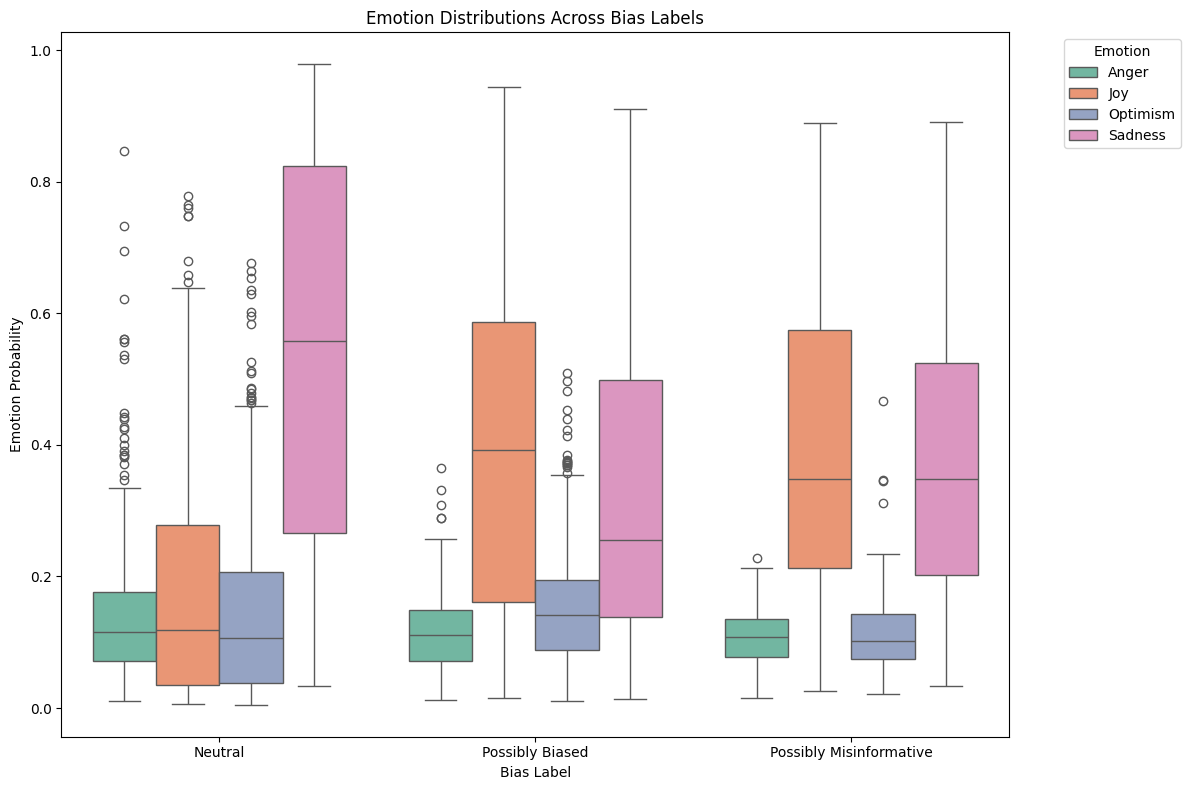

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

df_emotion = pd.read_csv("framing_emotion_output.csv")

# Assuming `df_emotion` contains the emotion columns
emotion_columns = ['emotion_anger', 'emotion_joy', 'emotion_optimism', 'emotion_sadness']

# Reshape the DataFrame to long format
df_long = df_emotion.melt(
    id_vars=["bias_label"], 
    value_vars=emotion_columns, 
    var_name="Emotion", 
    value_name="Probability"
)

# Remove "emotion_" prefix from emotion names for clarity
df_long["Emotion"] = df_long["Emotion"].str.replace("emotion_", "").str.capitalize()

# Create a grouped boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_long, x="bias_label", y="Probability", hue="Emotion", palette="Set2")

# Customize the plot
plt.title("Emotion Distributions Across Bias Labels")
plt.xlabel("Bias Label")
plt.ylabel("Emotion Probability")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Axes: xlabel='bias_label', ylabel='emotion_anger'>

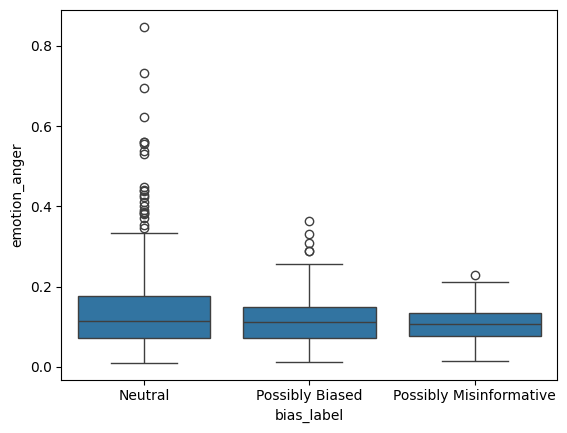

In [7]:
import seaborn as sns
sns.boxplot(data=df_emotion, x="bias_label", y="emotion_anger")


<Axes: xlabel='bias_label', ylabel='emotion_sadness'>

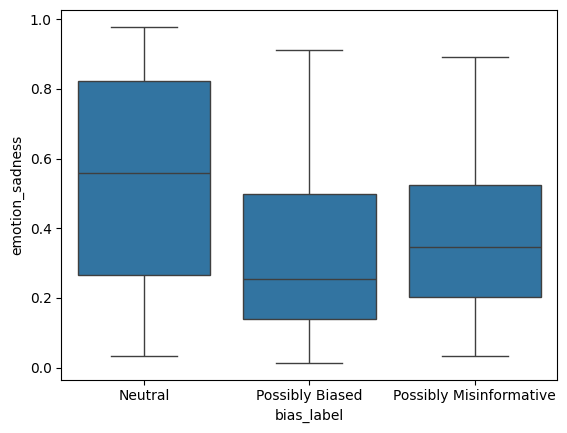

In [8]:
sns.boxplot(data=df_emotion, x="bias_label", y="emotion_sadness")


<Axes: xlabel='bias_label', ylabel='emotion_optimism'>

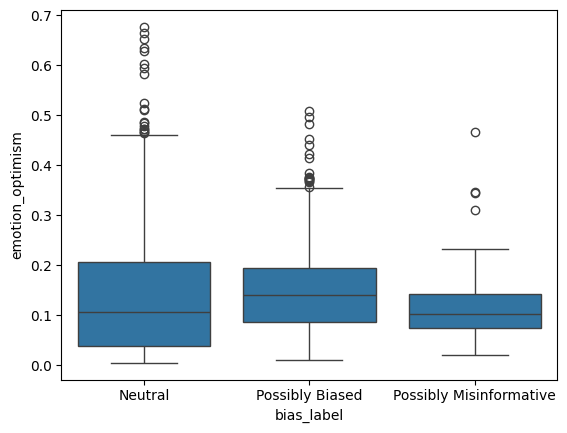

In [9]:
sns.boxplot(data=df_emotion, x="bias_label", y="emotion_optimism")


<Axes: xlabel='bias_label', ylabel='emotion_joy'>

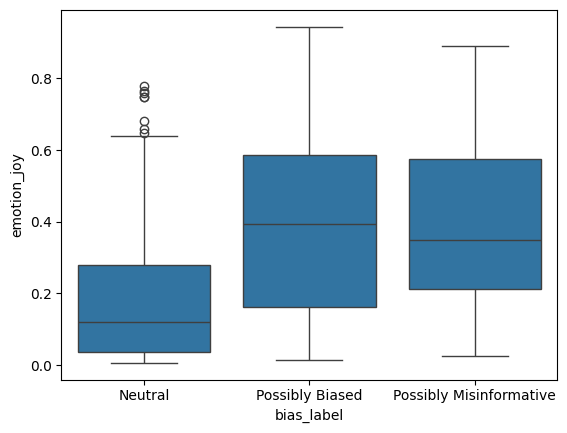

In [10]:
sns.boxplot(data=df_emotion, x="bias_label", y="emotion_joy")

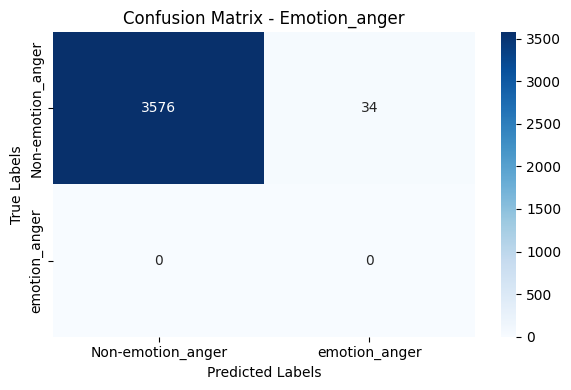

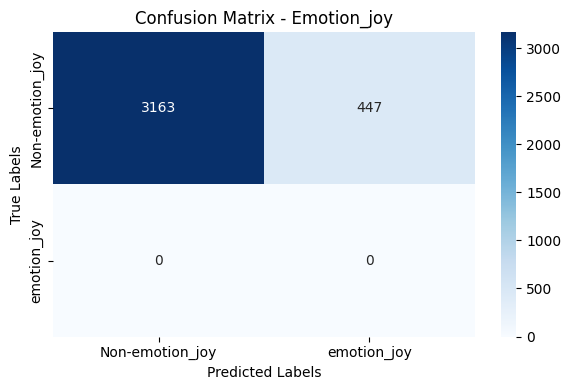

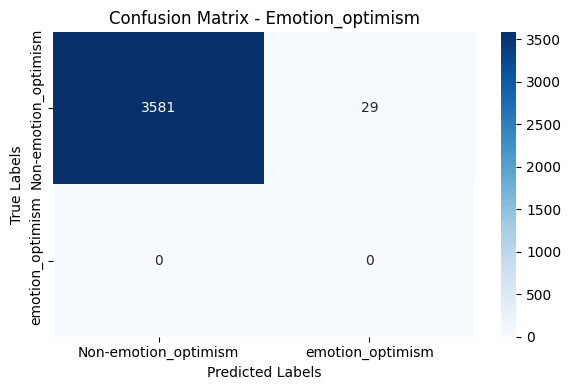

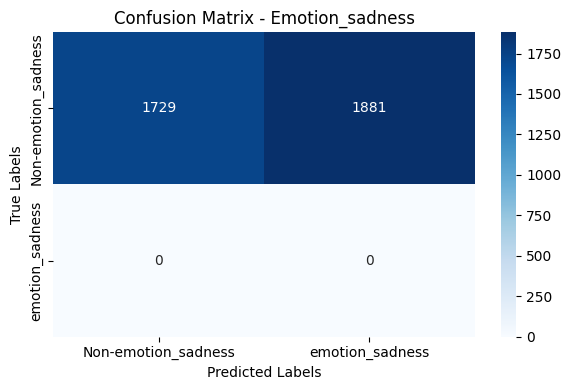

                  Accuracy  Precision  Recall  F1-Score
emotion_anger     0.990582        0.0     0.0       0.0
emotion_joy       0.876177        0.0     0.0       0.0
emotion_optimism  0.991967        0.0     0.0       0.0
emotion_sadness   0.478947        0.0     0.0       0.0


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# List of emotion columns
emotion_columns = ['emotion_anger', 'emotion_joy', 'emotion_optimism', 'emotion_sadness']

# Initialize metrics storage
metrics = {}

for emotion in emotion_columns:
    true_labels = (df_emotion['bias_label'] == emotion).astype(int)  # Convert to binary ground truth for each emotion
    predicted_labels = (df_emotion[emotion] >= 0.5).astype(int)  # Threshold probabilities (0.5)
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    
    # Store results
    metrics[emotion] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-" + emotion, emotion], yticklabels=["Non-" + emotion, emotion])
    plt.title(f"Confusion Matrix - {emotion.capitalize()}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

# Display metrics for all emotions
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)
